
DATA PREPROCESSING

In [1]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv("data/final_personal_finance_dataset.csv")
print(f"[INFO] Loaded dataset | rows={len(df):,}  cols={len(df.columns)}")

[INFO] Loaded dataset | rows=15,767  cols=10


In [2]:
print("\n[INFO] Columns available:", df.columns.tolist())


[INFO] Columns available: ['Date', 'Transaction Description', 'Category', 'Amount', 'Type', 'UserID', 'TransactionID', 'Currency', 'Merchant', 'Account Name']


In [3]:
if "UserID" in df.columns:
    print("\n[INFO] Unique Users:", df["UserID"].nunique())
    print(df["UserID"].value_counts().to_string())


[INFO] Unique Users: 8
UserID
US009    2461
US002    2208
US003    2191
US004    2154
US006    2128
US005    2125
US001    1500
US008    1000


In [4]:
if "Category" in df.columns:
    print("\n[INFO] Unique Categories:", df["Category"].nunique())
    print(df["Category"].value_counts().head(15).to_string())


[INFO] Unique Categories: 81
Category
Credit Card Payment    1781
Groceries              1446
Restaurants            1188
Shopping               1009
Utilities              1001
Food                    907
Gas & Fuel              647
Paycheck                637
Home Improvement        441
Coffee Shops            431
Auto Insurance          383
Internet                330
Transportation          307
Alcohol & Bars          276
Other                   262


In [5]:
if "Merchant" in df.columns:
    print("\n[INFO] Sample Merchants:", df["Merchant"].dropna().unique()[:15])



[INFO] Sample Merchants: ['Subway' 'Duke Energy' 'Apartment Complex' 'Vanguard' 'McDonalds'
 'Best Buy' 'Generic Merchant' 'Netflix' 'Landlord' 'Starbucks'
 'Zillow Rentals' 'Charles Schwab' 'Spotify' 'Dunkin' 'Target']


In [6]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)

In [7]:
df["YearMonth"] = df["Date"].dt.to_period("M")

In [8]:
if "Merchant" in df.columns:
    if "Transaction Description" in df.columns:
        df["raw_text"] = (
            df["Merchant"].fillna("").astype(str) + " " +
            df["Transaction Description"].fillna("").astype(str)
        )
    else:
        df["raw_text"] = df["Merchant"].fillna("").astype(str)
else:
    if "Transaction Description" in df.columns:
        df["raw_text"] = df["Transaction Description"].fillna("").astype(str)
    else:
        df["raw_text"] = ""

In [9]:
df["clean_desc"] = (
    df["raw_text"].str.lower()
    .str.replace(r"[^a-z0-9 ]+", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
    .str.replace(r"\b\d+\b", "<NUM>", regex=True)
)

print("\n[HEAD SAMPLE]")
cols_to_show = [c for c in ["Date","UserID","Type","Amount","Category","Merchant",
                            "Transaction Description","raw_text","clean_desc","YearMonth"]
                if c in df.columns]
print(df[cols_to_show].head(8).to_string(index=False))


[HEAD SAMPLE]
      Date UserID    Type  Amount       Category Merchant                   Transaction Description                                   raw_text                            clean_desc YearMonth
2015-01-13  US009 Expense    10.0           Food      NaN                                       tea                                        tea                                   tea   2015-01
2015-01-13  US009 Expense   500.0          Other      NaN                          Internet renewal                           Internet renewal                      internet renewal   2015-01
2015-01-14  US009 Expense   760.0 Transportation      NaN                   travels - Mumbai to brc                    travels - Mumbai to brc                 travels mumbai to brc   2015-01
2015-01-14  US009 Expense   120.0           Food      NaN Lunch - chicken fried rice + chicken soup  Lunch - chicken fried rice + chicken soup lunch chicken fried rice chicken soup   2015-01
2015-01-14  US009 Expense    1

In [10]:
# Ensure Date and YearMonth are already set from earlier
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)
df["YearMonth"] = df["Date"].dt.to_period("M")

# Average Monthly Income & Expense per User 
avg_features = (
    df.groupby(["UserID", "Type", "YearMonth"])["Amount"]
      .sum()
      .reset_index()
)

pivot = avg_features.pivot_table(
    index="UserID", columns="Type", values="Amount", aggfunc="mean", fill_value=0
).reset_index()

pivot.rename(columns={"Expense": "AvgMonthlyExpense", "Income": "AvgMonthlyIncome"}, inplace=True)

print("\n[INFO] Average income/expense per user:")
print(pivot.head())


[INFO] Average income/expense per user:
Type UserID  AvgMonthlyExpense  AvgMonthlyIncome  Transfer-Out
0     US001       20453.239500      12234.783333           0.0
1     US002        4603.662083       5049.069600           0.0
2     US003        4826.503462       5418.592400           0.0
3     US004        5173.187200       4900.080400           0.0
4     US005        4709.362500       5269.466667           0.0


In [11]:
# === 2. Subscription Detection ===
def detect_subscriptions(user_df: pd.DataFrame):
    """Detect recurring merchants (appear ≥3 months)."""
    exp = user_df[user_df["Type"] == "Expense"].copy()
    if exp.empty:
        return []
    months_per_merchant = exp.groupby("Merchant")["YearMonth"].nunique()
    subs = months_per_merchant[months_per_merchant >= 3].index.tolist()
    return subs

sub_rows = []
for uid, g in df.groupby("UserID"):
    subs = detect_subscriptions(g)
    sub_rows.append({
        "UserID": uid,
        "SubscriptionCount": len(subs),
        "SubscriptionMerchants": subs
    })

subs_df = pd.DataFrame(sub_rows)
print("\n[INFO] Subscription detection sample:")
print(subs_df.head())


[INFO] Subscription detection sample:
  UserID  SubscriptionCount                              SubscriptionMerchants
0  US001                 20  [AMC Theatres, AT&T, Amazon, Apartment Complex...
1  US002                 40  [Amazon, American Tavern, BP, Barbershop, Belg...
2  US003                 40  [Amazon, American Tavern, BBQ Restaurant, BP, ...
3  US004                 41  [Amazon, American Tavern, BBQ Restaurant, BP, ...
4  US005                 42  [Amazon, American Tavern, BBQ Restaurant, BP, ...


In [12]:
user_summary = pivot.merge(subs_df, on="UserID", how="left")
print("\n[INFO] User-level summary (income, expense, subscriptions):")
print(user_summary.head())


[INFO] User-level summary (income, expense, subscriptions):
  UserID  AvgMonthlyExpense  AvgMonthlyIncome  Transfer-Out  \
0  US001       20453.239500      12234.783333           0.0   
1  US002        4603.662083       5049.069600           0.0   
2  US003        4826.503462       5418.592400           0.0   
3  US004        5173.187200       4900.080400           0.0   
4  US005        4709.362500       5269.466667           0.0   

   SubscriptionCount                              SubscriptionMerchants  
0                 20  [AMC Theatres, AT&T, Amazon, Apartment Complex...  
1                 40  [Amazon, American Tavern, BP, Barbershop, Belg...  
2                 40  [Amazon, American Tavern, BBQ Restaurant, BP, ...  
3                 41  [Amazon, American Tavern, BBQ Restaurant, BP, ...  
4                 42  [Amazon, American Tavern, BBQ Restaurant, BP, ...  


TEXT EMBEDDINGS


TF-IDF char n-gram features

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer
import numpy as np


print("\n[INFO] Building TF-IDF features...")
vectorizer = TfidfVectorizer(
    analyzer="char_wb", ngram_range=(3, 5), min_df=2  
)
tfidf_matrix = vectorizer.fit_transform(df["clean_desc"])
print("[INFO] TF-IDF matrix shape:", tfidf_matrix.shape)

f:\Third Year\FYP New\Projects\Loomi\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[INFO] Building TF-IDF features...
[INFO] TF-IDF matrix shape: (15767, 12251)


SBERT embeddings

In [14]:
print("\n[INFO] Building SBERT embeddings...")
model = SentenceTransformer("all-MiniLM-L6-v2")  
sbert_embeddings = model.encode(
    df["clean_desc"].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True
)
print("[INFO] SBERT embedding shape:", sbert_embeddings.shape)


[INFO] Building SBERT embeddings...


Batches: 100%|██████████| 493/493 [00:42<00:00, 11.74it/s]


[INFO] SBERT embedding shape: (15767, 384)


Reduce TF-IDF (TruncatedSVD)

In [15]:
N_SVD = 200  
print("\n[INFO] Reducing TF-IDF with SVD to", N_SVD)
svd = TruncatedSVD(n_components=min(N_SVD, tfidf_matrix.shape[1]-1), random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)
print("[INFO] Reduced TF-IDF shape:", tfidf_reduced.shape)

combined_features = np.hstack([tfidf_reduced, sbert_embeddings])
print("[INFO] Combined feature matrix shape:", combined_features.shape)


[INFO] Reducing TF-IDF with SVD to 200
[INFO] Reduced TF-IDF shape: (15767, 200)
[INFO] Combined feature matrix shape: (15767, 584)


In [16]:
import faiss

d = combined_features.shape[1]
index = faiss.IndexFlatL2(d)   # L2 distance
index.add(combined_features.astype(np.float32))
print(f"[INFO] FAISS index built with {index.ntotal} vectors of dim {d}")

# Example query: find 5 nearest neighbors for first row
D, I = index.search(combined_features[:1].astype(np.float32), k=5)
print("[INFO] Sample NN query (row 0):", I, D)

[INFO] FAISS index built with 15767 vectors of dim 584
[INFO] Sample NN query (row 0): [[ 0  5 11 24 25]] [[0. 0. 0. 0. 0.]]


In [17]:
import hdbscan
from sklearn.cluster import KMeans

USE_KMEANS = True   # Toggle: True = KMeans, False = HDBSCAN

if USE_KMEANS:
    K_FOR_KMEANS = 25   # you can tune this
    print(f"\n[INFO] Running KMeans with k={K_FOR_KMEANS} ...")
    kmeans = KMeans(n_clusters=K_FOR_KMEANS, random_state=42, n_init=10)
    labels = kmeans.fit_predict(combined_features)
else:
    print("\n[INFO] Running HDBSCAN ...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric="euclidean")
    labels = clusterer.fit_predict(combined_features)

df["ClusterID"] = labels
n_clusters = len(set(labels) - {-1})
print(f"[INFO] Clusters formed: {n_clusters}")


[INFO] Running KMeans with k=25 ...
[INFO] Clusters formed: 25


In [18]:
# 3) Extract Exemplars (canonical merchant names)
exemplars = (
    df[df["ClusterID"] != -1]
    .groupby("ClusterID")["Merchant"]
    .agg(lambda s: s.value_counts().index[0] if not s.isna().all() else "Unknown")
    .to_dict()
)

df["CanonicalMerchant"] = df["ClusterID"].map(exemplars)

print("\n[INFO] Cluster Exemplars (first 10):")
print(dict(list(exemplars.items())[:10]))


[INFO] Cluster Exemplars (first 10):
{0: 'target', 1: 'American Tavern', 2: 'auto', 3: 'Mortgage Payment', 4: 'Credit Card Payment', 5: 'Biweekly Paycheck', 6: 'Gas Company', 7: 'Grocery Store', 8: 'Phone Company', 9: 'Amazon'}


In [19]:
# Weak Supervision Category Mapping
def weak_category_mapping(merchant: str, category: str) -> str:
    m = str(merchant).lower()
    c = str(category).lower()
    # Rules (extend as needed)
    if any(k in m for k in ["starbucks", "dunkin", "coffee"]): return "Food & Drink"
    if any(k in m for k in ["walmart", "target", "best buy", "shopping"]): return "Shopping"
    if any(k in m for k in ["netflix", "spotify", "hulu", "prime"]): return "Entertainment"
    if "apartment" in m or "landlord" in m: return "Rent"
    if "uber" in m or "taxi" in m or "lyft" in m: return "Transportation"
    if "verizon" in m or "duke energy" in m or "utilities" in c: return "Utilities"
    if "fidelity" in m or "vanguard" in m or "investment" in c: return "Investment"
    return category  # fallback to original

df["MappedCategory"] = df.apply(
    lambda r: weak_category_mapping(r["CanonicalMerchant"], r["Category"]),
    axis=1
)

print("\n[INFO] Sample of cluster + canonical merchant + mapped category:")
print(df[["ClusterID", "Merchant", "CanonicalMerchant", "Category", "MappedCategory"]].head(15))


[INFO] Sample of cluster + canonical merchant + mapped category:
    ClusterID Merchant          CanonicalMerchant        Category  \
0           2      NaN                       auto            Food   
1          14      NaN  Internet Service Provider           Other   
2           2      NaN                       auto  Transportation   
3           2      NaN                       auto            Food   
4           2      NaN                       auto            Food   
5           2      NaN                       auto            Food   
6           2      NaN                       auto  Transportation   
7           2      NaN                       auto            Food   
8           2      NaN                       auto  Transportation   
9           2      NaN                       auto  Transportation   
10          2      NaN                       auto  Transportation   
11          2      NaN                       auto            Food   
12         24      NaN               

Behavioral Analysis

In [20]:
# --- Payday spike ratio ---
def payday_spike_ratio(g: pd.DataFrame) -> float:
    """% of monthly expenses spent in 7 days after last income."""
    income = g[g["Type"] == "Income"]
    if income.empty:
        return 0.0
    salary_like = income[income["Category"].str.contains("paycheck|salary", case=False, na=False)]
    if salary_like.empty:
        last_income_date = income.loc[income["Amount"].idxmax(), "Date"]
    else:
        last_income_date = salary_like["Date"].max()
    exp = g[g["Type"] == "Expense"]
    if exp.empty:
        return 0.0
    window_end = last_income_date + pd.Timedelta(days=7)
    post_pay = exp[(exp["Date"] >= last_income_date) & (exp["Date"] <= window_end)]["Amount"].sum()
    month_period = last_income_date.to_period("M")
    total_month_exp = exp[exp["YearMonth"] == month_period]["Amount"].sum()
    return float(post_pay / total_month_exp) if total_month_exp > 0 else 0.0

In [21]:
# --- Micro-spending count ---
def micro_spending_count(g: pd.DataFrame, threshold=10.0, days=30) -> int:
    """Count of expenses below threshold in the last N days."""
    end = g["Date"].max()
    start = end - pd.Timedelta(days=days)
    mask = (g["Type"] == "Expense") & (g["Date"].between(start, end)) & (g["Amount"] < threshold)
    return int(mask.sum())

In [22]:
# --- Subscription creep (reuse from preprocessing) ---
def subscription_count(g: pd.DataFrame) -> int:
    exp = g[g["Type"] == "Expense"].copy()
    if exp.empty:
        return 0
    months_per_merchant = exp.groupby("Merchant")["YearMonth"].nunique()
    return int((months_per_merchant >= 3).sum())

In [23]:
# --- Spending volatility ---
def spending_volatility(g: pd.DataFrame) -> float:
    """Std/mean ratio of monthly expenses (coefficient of variation)."""
    monthly = g[g["Type"] == "Expense"].groupby("YearMonth")["Amount"].sum()
    if len(monthly) <= 1:
        return 0.0
    return float(monthly.std() / (monthly.mean() + 1e-6))

In [24]:
# --- Run per user ---
features = []
for uid, g in df.groupby("UserID"):
    g = g.sort_values("Date")
    feats = {
        "UserID": uid,
        "micro_count_30d": micro_spending_count(g, threshold=10.0, days=30),
        "payday_spike_ratio": payday_spike_ratio(g),
        "subscription_count": subscription_count(g),
        "spending_volatility": spending_volatility(g),
        "monthly_income": g[g["Type"]=="Income"].groupby("YearMonth")["Amount"].sum().mean(),
        "monthly_expense": g[g["Type"]=="Expense"].groupby("YearMonth")["Amount"].sum().mean()
    }
    features.append(feats)

feat_df = pd.DataFrame(features).fillna(0.0)

print("\n[INFO] Behavioral feature sample:")
print(feat_df.head())


[INFO] Behavioral feature sample:
  UserID  micro_count_30d  payday_spike_ratio  subscription_count  \
0  US001                0            0.332194                  20   
1  US002                0            0.341654                  40   
2  US003                0            0.567736                  40   
3  US004                0            0.426394                  41   
4  US005                0            0.146234                  42   

   spending_volatility  monthly_income  monthly_expense  
0             0.250336    12234.783333     20453.239500  
1             0.385546     5049.069600      4603.662083  
2             0.640184     5418.592400      4826.503462  
3             0.484676     4900.080400      5173.187200  
4             0.426917     5269.466667      4709.362500  


In [25]:
# --- Bias flag rules ---
def make_flags(row):
    return {
        "present_bias": row["payday_spike_ratio"] > 0.5,       # >50% spent in first week
        "micro_spender": row["micro_count_30d"] > 20,          # >20 small txns last 30 days
        "subscription_creep": row["subscription_count"] > 5,   # >5 recurring subs
        "overspending": row["monthly_expense"] > row["monthly_income"],  # expense > income
        "volatile_spender": row["spending_volatility"] > 0.5   # very unstable month-to-month
    }

flag_rows = []
for _, r in feat_df.iterrows():
    flags = make_flags(r)
    flags["UserID"] = r["UserID"]
    flag_rows.append(flags)

flags_df = pd.DataFrame(flag_rows)

print("\n[INFO] Behavioral bias flags sample:")
print(flags_df.head())


[INFO] Behavioral bias flags sample:
   present_bias  micro_spender  subscription_creep  overspending  \
0         False          False                True          True   
1         False          False                True         False   
2          True          False                True         False   
3         False          False                True          True   
4         False          False                True         False   

   volatile_spender UserID  
0             False  US001  
1             False  US002  
2              True  US003  
3             False  US004  
4             False  US005  


In [26]:
# --- Category share in latest month ---
def top_category_share(g: pd.DataFrame) -> float:
    """Highest single-category share of expenses in the latest month."""
    latest = g["YearMonth"].max()
    exp = g[(g["Type"] == "Expense") & (g["YearMonth"] == latest)]
    if exp.empty:
        return 0.0
    by_cat = exp.groupby("Category")["Amount"].sum()
    total = by_cat.sum()
    if total <= 0:
        return 0.0
    return float((by_cat / total).max())

# Extend features with top category share
extra_feats = []
for uid, g in df.groupby("UserID"):
    extra_feats.append({
        "UserID": uid,
        "top_category_share": top_category_share(g)
    })
extra_df = pd.DataFrame(extra_feats)

feat_df = feat_df.merge(extra_df, on="UserID", how="left")

# Update bias flag rules to include mental accounting
def make_flags(row):
    return {
        "present_bias": row["payday_spike_ratio"] > 0.5,
        "micro_spender": row["micro_count_30d"] > 20,
        "subscription_creep": row["subscription_count"] > 5,
        "overspending": row["monthly_expense"] > row["monthly_income"],
        "volatile_spender": row["spending_volatility"] > 0.5,
        "mental_accounting": row["top_category_share"] > 0.4   # >40% of spend in one category
    }

flag_rows = []
for _, r in feat_df.iterrows():
    f = make_flags(r)
    f["UserID"] = r["UserID"]
    flag_rows.append(f)
flags_df = pd.DataFrame(flag_rows)

print("\n[INFO] Updated flags sample:")
print(flags_df.head())



[INFO] Updated flags sample:
   present_bias  micro_spender  subscription_creep  overspending  \
0         False          False                True          True   
1         False          False                True         False   
2          True          False                True         False   
3         False          False                True          True   
4         False          False                True         False   

   volatile_spender  mental_accounting UserID  
0             False               True  US001  
1             False              False  US002  
2              True               True  US003  
3             False               True  US004  
4             False               True  US005  


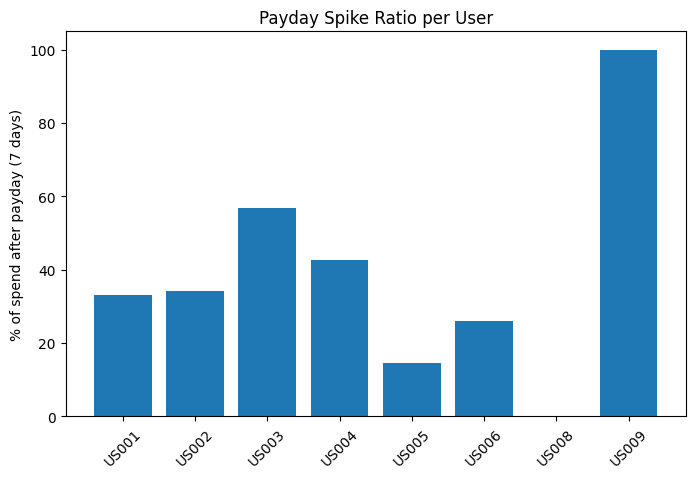

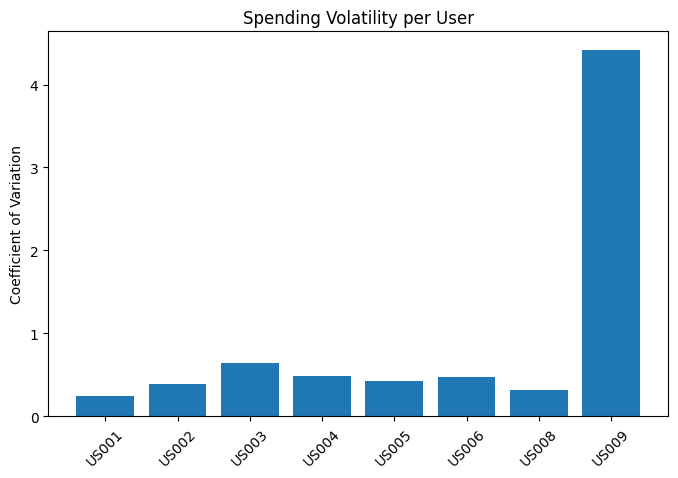

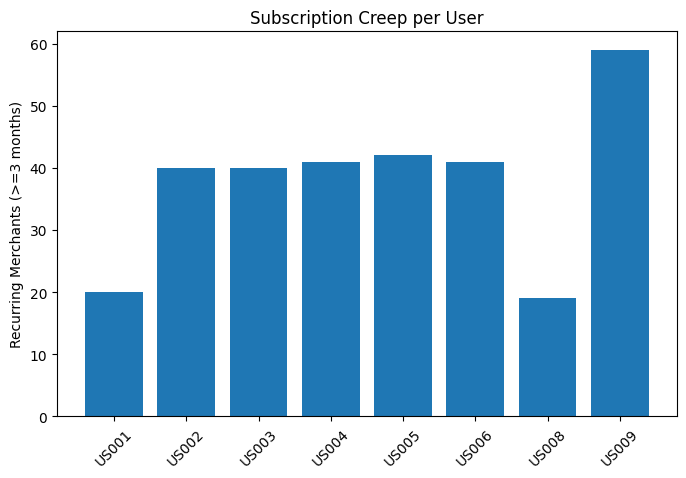

In [27]:
import matplotlib.pyplot as plt

# --- Payday spike ratios ---
plt.figure(figsize=(8,5))
plt.bar(feat_df["UserID"], feat_df["payday_spike_ratio"]*100)
plt.ylabel("% of spend after payday (7 days)")
plt.title("Payday Spike Ratio per User")
plt.xticks(rotation=45)
plt.show()

# --- Spending volatility ---
plt.figure(figsize=(8,5))
plt.bar(feat_df["UserID"], feat_df["spending_volatility"])
plt.ylabel("Coefficient of Variation")
plt.title("Spending Volatility per User")
plt.xticks(rotation=45)
plt.show()

# --- Subscription counts ---
plt.figure(figsize=(8,5))
plt.bar(feat_df["UserID"], feat_df["subscription_count"])
plt.ylabel("Recurring Merchants (>=3 months)")
plt.title("Subscription Creep per User")
plt.xticks(rotation=45)
plt.show()


In [28]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Example target: overspending flag
X = feat_df.drop(columns=["UserID"])
y = flags_df["overspending"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\n[INFO] LightGBM classification report (predict overspenders):")
print(classification_report(y_test, y_pred))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 2, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 5, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400000 -> initscore=-0.405465
[LightGBM] [Info] Start training from score -0.405465
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

f:\Third Year\FYP New\Projects\Loomi\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Third Year\FYP New\Projects\Loomi\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Third Year\FYP New\Projects\Loomi\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

In [29]:
import pandas as pd

# --- Cluster Summary Table ---
def cluster_summary_table(df, exemplars, n=10):
    sample = (
        df[["ClusterID","Merchant","CanonicalMerchant","Category","MappedCategory"]]
        .dropna()
        .head(n)
    )
    ex_df = pd.DataFrame(list(exemplars.items()), columns=["ClusterID","Exemplar"]).head(n)
    print("\n=== CLUSTER SUMMARY ===")
    display(ex_df)   # shows exemplars nicely
    display(sample)  # shows sample assignments

cluster_summary_table(df, exemplars)

# --- Behavior Features Table ---
def behavior_features_table(feat_df, n=8):
    display(
        feat_df[["UserID","payday_spike_ratio","micro_count_30d",
                 "subscription_count","spending_volatility",
                 "top_category_share","monthly_income","monthly_expense"]]
        .round(3)
        .head(n)
    )

print("\n=== BEHAVIORAL FEATURES (per user) ===")
behavior_features_table(feat_df)

# --- Behavior Flags Table (with ✓ / ✗ instead of True/False) ---
def flags_table(flags_df, n=8):
    df_copy = flags_df.copy()
    for col in df_copy.columns:
        if col != "UserID":
            df_copy[col] = df_copy[col].map({True:"✓", False:"✗"})
    display(df_copy.head(n))

print("\n=== BEHAVIORAL FLAGS (bias indicators) ===")
flags_table(flags_df)

# --- Insights Table ---
pd.set_option("display.max_colwidth", None)

def insights_table(feat_df, flags_df):
    merged = feat_df.merge(flags_df, on="UserID")
    rows = []
    for _, row in merged.iterrows():
        msgs = []
        if row["present_bias"]: msgs.append("Present Bias")
        if row["micro_spender"]: msgs.append("Micro-Spender")
        if row["subscription_creep"]: msgs.append("Subscription Creep")
        if row["overspending"]: msgs.append("Overspending")
        if row["volatile_spender"]: msgs.append("Volatile Spender")
        if row["mental_accounting"]: msgs.append("Mental Accounting")
        rows.append({
            "UserID": row["UserID"], 
            "Detected Flags": ", ".join(msgs) if msgs else "None"
        })
    insights_df = pd.DataFrame(rows)
    display(insights_df)

print("\n=== NARRATIVE INSIGHTS ===")
insights_table(feat_df, flags_df)



=== CLUSTER SUMMARY ===


,ClusterID,Exemplar
0,0,target
1,1,American Tavern
2,2,auto
3,3,Mortgage Payment
4,4,Credit Card Payment
5,5,Biweekly Paycheck
6,6,Gas Company
7,7,Grocery Store
8,8,Phone Company
9,9,Amazon


,ClusterID,Merchant,CanonicalMerchant,Category,MappedCategory
51,2,Medicine,auto,Health,Health
52,2,Health,auto,Health,Health
55,2,Train,auto,Transportation,Transportation
56,2,train,auto,Transportation,Transportation
57,2,auto,auto,Transportation,Transportation
58,2,Footwear,auto,Apparel,Apparel
59,2,auto,auto,Transportation,Transportation
60,2,Grocery,auto,Food,Food
61,2,Tea,auto,Food,Food
62,2,auto,auto,Transportation,Transportation



=== BEHAVIORAL FEATURES (per user) ===


,UserID,payday_spike_ratio,micro_count_30d,subscription_count,spending_volatility,top_category_share,monthly_income,monthly_expense
0,US001,0.332,0,20,0.250,0.421,12234.783,20453.239
1,US002,0.342,0,40,0.386,0.000,5049.070,4603.662
2,US003,0.568,0,40,0.640,1.000,5418.592,4826.503
3,US004,0.426,0,41,0.485,0.490,4900.080,5173.187
4,US005,0.146,0,42,0.427,0.497,5269.467,4709.362
5,US006,0.260,0,41,0.473,0.000,4408.730,4742.589
6,US008,0.000,2,19,0.315,0.401,0.000,9675.937
7,US009,1.000,14,59,4.420,0.408,69145.394,42551.968



=== BEHAVIORAL FLAGS (bias indicators) ===


,present_bias,micro_spender,subscription_creep,overspending,volatile_spender,mental_accounting,UserID
0,✗,✗,✓,✓,✗,✓,US001
1,✗,✗,✓,✗,✗,✗,US002
2,✓,✗,✓,✗,✓,✓,US003
3,✗,✗,✓,✓,✗,✓,US004
4,✗,✗,✓,✗,✗,✓,US005
5,✗,✗,✓,✓,✗,✗,US006
6,✗,✗,✓,✓,✗,✓,US008
7,✓,✗,✓,✗,✓,✓,US009



=== NARRATIVE INSIGHTS ===


,UserID,Detected Flags
0,US001,"Subscription Creep, Overspending, Mental Accounting"
1,US002,Subscription Creep
2,US003,"Present Bias, Subscription Creep, Volatile Spender, Mental Accounting"
3,US004,"Subscription Creep, Overspending, Mental Accounting"
4,US005,"Subscription Creep, Mental Accounting"
5,US006,"Subscription Creep, Overspending"
6,US008,"Subscription Creep, Overspending, Mental Accounting"
7,US009,"Present Bias, Subscription Creep, Volatile Spender, Mental Accounting"
